In [1]:
%pylab inline
import os
import caffe
import torch
from torch_nets import load_net


caffe.set_mode_gpu()
inet_mean = np.array((104.0, 117.0, 123.0))    # BGR


def deprocess(im):
    im = np.rollaxis(im, -3, len(im.shape))
    im += inet_mean
    im = im[..., ::-1]
    return np.clip(im, 0, 255).astype(np.uint8)

Populating the interactive namespace from numpy and matplotlib


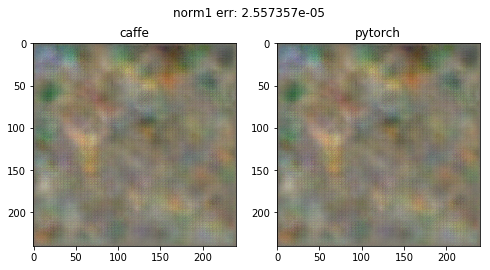

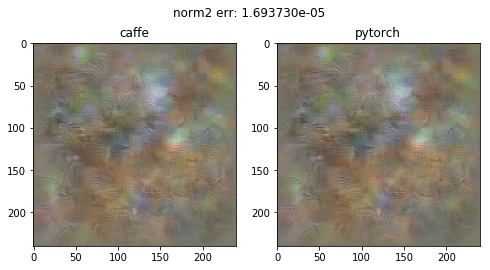

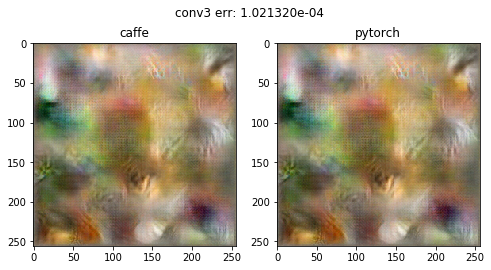

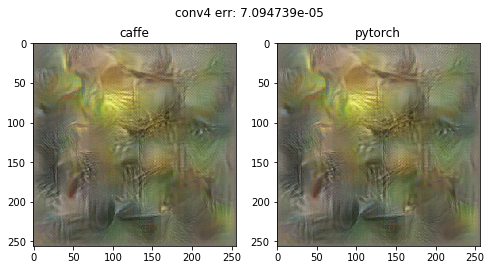

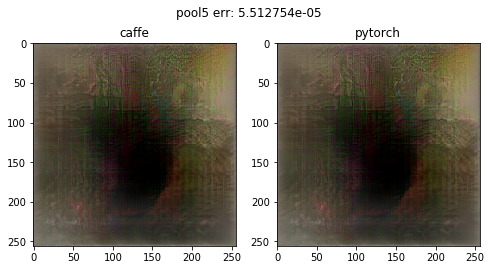

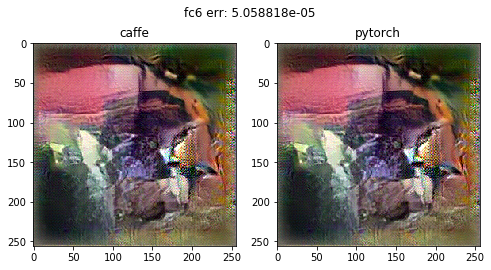

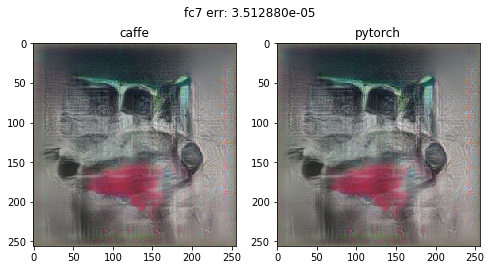

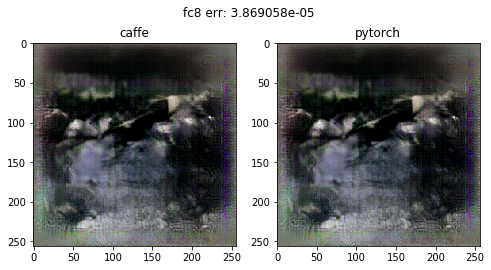

In [4]:
for net_name, i_shape, i_scale in zip(
        ('norm1', 'norm2', 'conv3', 'conv4', 'pool5', 'fc6', 'fc7', 'fc8'),
        ((96, 27, 27), (256, 13, 13), (384,13,13), (384, 13, 13), (256, 6, 6),
         (4096,), (4096,), (1000,)),
        (30, 10, 100, 30, 10, 1, 1, 0.1)
    ):
    
    netd = os.path.expanduser(f'~/Documents/nets/deepsim/{net_name}/generator_no_batch.prototxt')
    netw = os.path.expanduser(f'~/Documents/nets/deepsim/{net_name}/generator.caffemodel')
    tnetw = os.path.expanduser(f'~/Documents/nets/pytorch/deepsim/{net_name}.pt')
    cnet = caffe.Net(netd, caffe.TEST, weights=netw)
    tnet = load_net(f'deepsim-{net_name}')
    tnet.load_state_dict(torch.load(tnetw))
    tnet.to('cuda')
    
    code = np.random.normal(0, i_scale, size=(1, *i_shape)).astype(np.float32)
    tim = tnet.forward(torch.tensor(code, device='cuda'))
    tim = tim.detach().cpu().numpy()
    cim = cnet.forward(feat=code)['generated']

    err = np.abs(tim-cim).mean()

    fig, axs = subplots(1, 2, figsize=(8,4))
    axs[0].imshow(deprocess(cim)[0])
    axs[0].set_title('caffe')
    axs[1].imshow(deprocess(tim)[0])
    axs[1].set_title('pytorch')
    fig.suptitle(f'{net_name} err: {err:e}')

    del cnet, tnet